# Deterministic Dealer Model

- [1] M. Takayasu, K. Izumi, K. Yamada and T. Mizuta, マルチエージェントによる金融市場のシミュレーション, コロナ社
- [2] H. Takayasu, H. Miura, T. Hirabayashi and K. Hamada: Statistical properties of deterministic threshold elements - the case of market price, Pysica A: Statistical Mechanics and its Applications, 184, 1, pp. 127-134 (1992)
- [3] A. Sato and H. Takayasu: Dynamic numerical models of stock  market price: from microscopic determinism to macroscopic randomness, Pyysica A: Statistical Mechanics and its Applications, 250, 1, pp. 231-252 (1998)
- [4] K. Yamada, H. Takayasu and M. Takayasu: Characterization of foregin exchange market using the threshold-dealer-model, Physica A: Statistical Mechanics and its Applications, 382, 1, pp. 340-346 (2007)

In [210]:
import os

try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "fx")

## V1: The simplest multi agent model

In [238]:
import random

import pandas as pd

class DeterministicDealerModelV1:
    
    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001) -> None:
        # min_vol should be greater than 0
        # agent tendency: agent change his order prices based on the tendency
        tendency = pd.Series([random.uniform(min_volatility, max_volatility) for i in range(num_agent)], dtype=float)
        if trade_unit < 1:
            do_round = True
            decimal = 0.1
            decimal_num = 1
            while True:
                check = trade_unit / decimal
                if check >= 1 - trade_unit:
                    break
                decimal *= 0.1
                decimal_num += 1
                if decimal_num > 100:
                    do_round = False 
                    break
            if do_round is True:
                tendency = tendency.round(decimal_num)
        prices = pd.Series([random.uniform(initial_price, initial_price + spread) for i in range(num_agent)], dtype=float)
        if initial_positions is None:
            position_trends = pd.Series([random.choice([-1, 1]) for i in range(num_agent)], dtype=int)
        elif len(initial_positions) == num_agent:
            position_trends = pd.Series(initial_positions, dtype=int)
        else:
            raise ValueError("initial position is invalid.")
        self.agent_df = pd.concat([tendency, position_trends, prices], axis=1, keys=["tend", "position", "price"], names=["id"])
        self.spread = spread
        self.market_price = initial_price + self.spread
        self.__initial_price = initial_price
        self.__min_vol = min_volatility
        self.__max_vol = max_volatility
        self.trade_unit = trade_unit
        self.tick_time = 0.0
        self.tick_time_unit = tick_time
                
    def advance_order_price(self):
        self.agent_df.price += self.agent_df.position * self.agent_df.tend
        # print("*kept*")
        # print(self.agent_df)
        return self.agent_df.price
    
    def contruct(self):
        ask_agents = self.agent_df.loc[self.agent_df.position == 1]
        bought_agent_id = ask_agents.price.idxmax()
        ask_order_price = ask_agents.price[bought_agent_id]
        
        bid_agents = self.agent_df.loc[self.agent_df.position == -1]
        sold_agent_id = bid_agents.price.idxmin()
        bid_order_price = bid_agents.price[sold_agent_id] + self.spread
    
        if ask_order_price >= bid_order_price:
            # print("---contructed!!---")
            self.market_price = (((ask_order_price + bid_order_price)/2) // self.trade_unit) * self.trade_unit
            # print(bought_agent_id, sold_agent_id)
            self.agent_df.loc[bought_agent_id, "position"] = -1
            self.agent_df.loc[sold_agent_id, "position"] = 1
            # print(self.agent_df)
            return self.market_price
        return None
            
    
    def simulate(self, ticks_num:int):
        price_history = [self.market_price]
        tick_times = [self.tick_time]
        for tick in range(ticks_num):
            self.tick_time += self.tick_time_unit
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                price_history.append(price)
                tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(price_history, columns=["price"])
        return price_hist_df, tick_times

### Plot simulation results

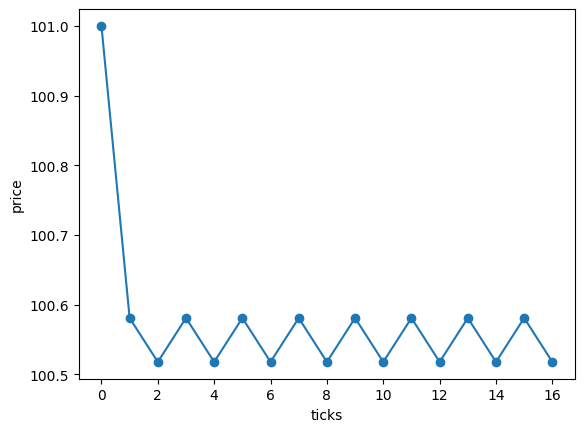

In [239]:
import matplotlib.pyplot as plt

# 2 agents model. it shows cyclic prices
model = DeterministicDealerModelV1(2, initial_positions=[1, -1])
prices, ticks = model.simulate(1000)
plt.plot(prices, marker="o")
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

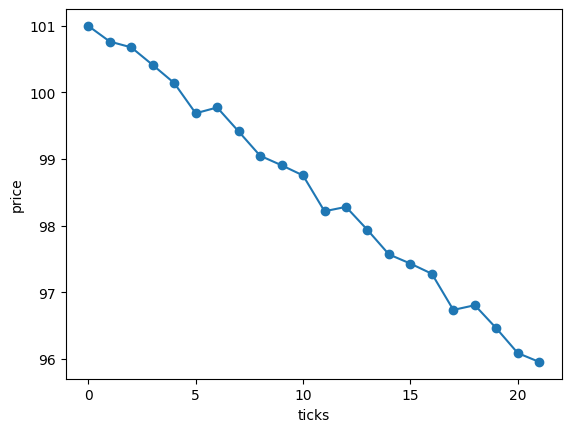

In [240]:
model = DeterministicDealerModelV1(3, initial_positions=[1, -1, -1])
prices, ticks = model.simulate(1000)
plt.plot(prices, marker="o")
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

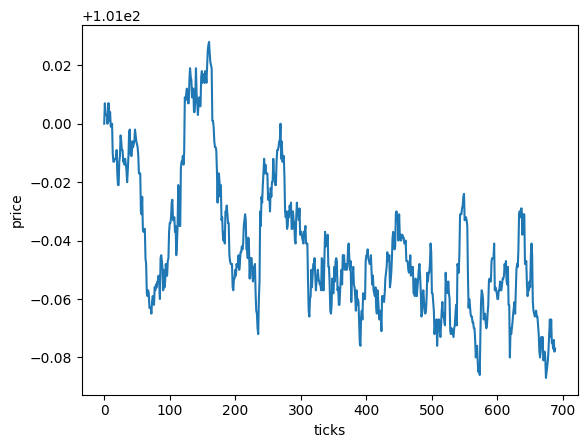

In [241]:
model = DeterministicDealerModelV1(300)
prices, ticks = model.simulate(1000)
plt.plot(prices)
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

### Validate statistical features

In [42]:
import numpy as np

tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.csv", index_col=0, parse_dates=True)
# remove market holiday
out_condition = 3600 * 24
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
min_span = time_diff[time_diff > 0].min()
time_span = np.round(time_diff/min_span)
mean_spread = tick_df.spread.mean()

In [309]:
agent_num = 300
simulation_ticks = 10000
additional_target_spread = [0.5, 1, 2, 4, 8]

In [312]:
price_results = []
ticks_results = []
labels = []

for target_spread in [mean_spread, *additional_target_spread]:
    model = DeterministicDealerModelV1(agent_num, tick_time=min_span, spread=target_spread)
    prices, ticks = model.simulate(simulation_ticks)
    price_results.append(prices)
    ticks_results.append(ticks)
    labels.append(f"sim({target_spread})")

In [281]:
def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

In [282]:
mean = tick_df["price"].diff().mean()
std = tick_df["price"].diff().std()

cumulative, bin_edges = cumulative_dist(tick_df["price"].diff().abs().iloc[1:], bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
n_cumulative, n_bin_edges = cumulative_dist(data)

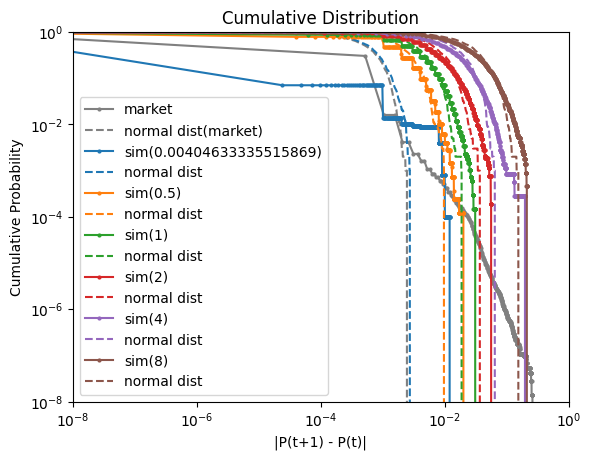

In [313]:
import matplotlib.colors as mcolors
colors = [*mcolors.TABLEAU_COLORS]

plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(n_bin_edges, n_cumulative, color="gray", linestyle="--", label="normal dist(market)")

for index in range(len(price_results)):
    prices = price_results[index]
    label = labels[index]
    color = colors[index]
    mean = prices["price"].diff().mean()
    std = prices["price"].diff().std()

    sim_cumulative, sim_bin_edges = cumulative_dist(prices["price"].diff().abs().iloc[1:], bins=500)
    num_samples = 1000
    data = abs(np.random.normal(mean, std, num_samples))
    sim_n_cumulative, sim_n_bin_edges = cumulative_dist(data)
    plt.plot(sim_bin_edges, sim_cumulative, color=color, marker="o", markersize=2, label=label)
    plt.plot(sim_n_bin_edges, sim_n_cumulative, color=color, linestyle="--", label="normal dist")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

In [288]:
def z(price_diff_srs, mean, std):
    return (price_diff_srs - mean)/std

def self_similarity(price_srs:pd.Series, k=100):
    base_mean = price_srs.mean()
    base_std = price_srs.std()
    base_z = z(price_srs, base_mean, base_std)
    
    sim_array = base_z.values * base_z.values
    similarities = [np.mean(sim_array)]
    sim_stds = [np.std(sim_array)]
    ks = [*range(0, k)]
    for i in ks[1:]:
        sim_array = base_z.values[i:] * base_z.values[:-i]
        mean_sim = np.mean(sim_array)
        std_sim = np.std(sim_array)
        similarities.append(mean_sim)
        sim_stds.append(std_sim)
    return ks, similarities, sim_stds

In [289]:
indices, similarities, _ = self_similarity(tick_df["price"].diff().iloc[1:], k=20)

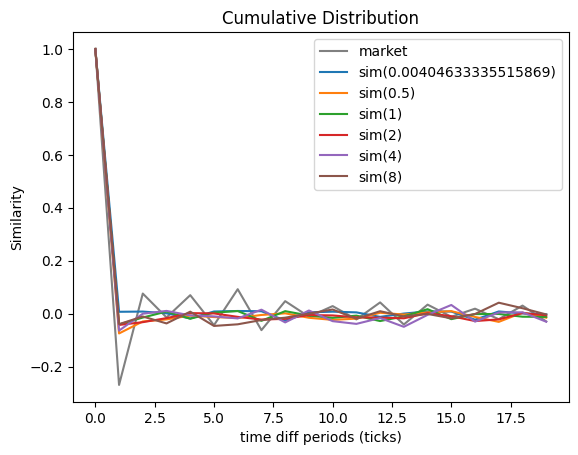

In [314]:
plt.plot(indices, similarities, color="gray", label="market")
for index in range(len(price_results)):
    prices = price_results[index]
    label = labels[index]
    color = colors[index]
    sim_indices, sim_similarities, _ = self_similarity(prices["price"].diff().iloc[1:], k=20)
    plt.plot(sim_indices, sim_similarities, color=color, label=label)
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

In [291]:
def diffusion(price_srs, n):
    if isinstance(price_srs, pd.Series):
        diff = price_srs.diff(periods=n).dropna()
        return diff.var()
    else:
        diff = (price_srs[:-n] - price_srs[n:])
        p_mean = (diff ** 2).mean()
        mean_p = (diff.mean()) ** 2
        return p_mean - mean_p

In [292]:
periods = [2**i for i in range(0, 11)]
var_diffusions = np.array([diffusion(tick_df["price"], period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

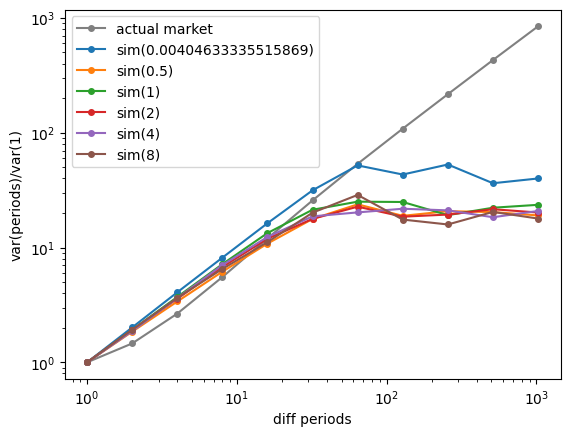

In [315]:
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color="gray", linestyle="-", marker="o", markersize=4)

for index in range(len(price_results)):
    prices = price_results[index]
    label = labels[index]
    color = colors[index]
    sim_var_diffusions = np.array([diffusion(prices["price"], period) for period in periods])
    sim_std_diffusions = np.sqrt(sim_var_diffusions)
    plt.plot(periods, sim_var_diffusions/sim_var_diffusions[0], label=label, color=color, linestyle="-", marker="o", markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("diff periods")
plt.ylabel("var(periods)/var(1)")
plt.legend()
plt.show()

In [295]:
# actual market result
counts = [len(time_span)]
spans = [*range(0, 1010, 10)]
for span in spans[1:]:
    match_spans = time_span[(time_span >= span)]
    count = len(match_spans)
    counts.append(count)
cum_p = np.asarray(counts)/len(time_span)

In [318]:
# simulation result
def cum_prob(ticks):
    ticks = np.asarray(ticks)
    transaction_spans = (ticks[1:] - ticks[:-1])/model.tick_time_unit

    counts = [len(transaction_spans)]
    sim_spans = [*range(0, 1002, 2)]
    for span in sim_spans[1:]:
        match_spans = transaction_spans[(transaction_spans >= span)]
        count = len(match_spans)
        if count == 0:
            break
        counts.append(count)
    sim_spans = sim_spans[:len(counts)]
    sim_cum_p = np.asarray(counts)/len(transaction_spans)
    return sim_spans, sim_cum_p

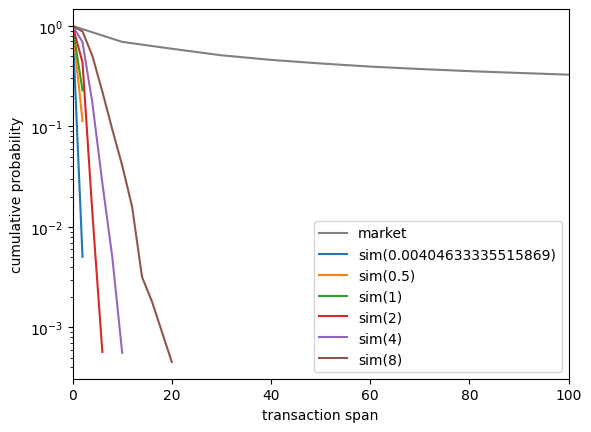

In [319]:
plt.plot(spans, cum_p, color="gray", label="market")
for index in range(len(price_results)):
    ticks = ticks_results[index]
    label = labels[index]
    color = colors[index]
    sim_spans, sim_cum_p = cum_prob(ticks)
    plt.plot(sim_spans, sim_cum_p, color=color, label=label)
plt.yscale("log")
plt.xlabel("transaction span")
plt.ylabel("cumulative probability")
plt.xlim(0, 100)
plt.legend()
plt.show()

In [324]:
price_results = []
ticks_results = []
labels = []

for target_ticks in [300, 600, 1200, 2400]:
    model = DeterministicDealerModelV1(agent_num, tick_time=min_span)
    prices, ticks = model.simulate(target_ticks)
    price_results.append(prices)
    ticks_results.append(ticks)
    labels.append(f"sim(num={target_ticks})")

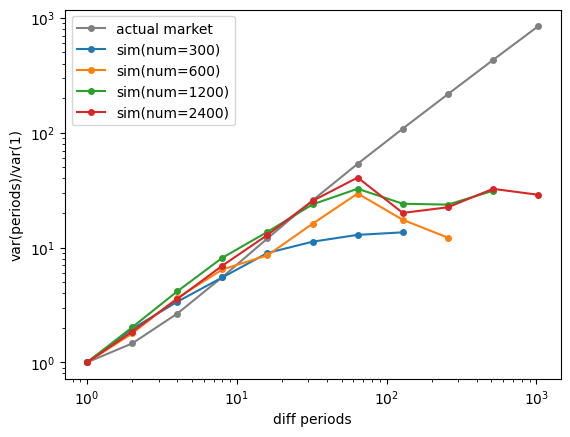

In [325]:
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color="gray", linestyle="-", marker="o", markersize=4)

for index in range(len(price_results)):
    prices = price_results[index]
    label = labels[index]
    color = colors[index]
    sim_var_diffusions = np.array([diffusion(prices["price"], period) for period in periods])
    sim_std_diffusions = np.sqrt(sim_var_diffusions)
    plt.plot(periods, sim_var_diffusions/sim_var_diffusions[0], label=label, color=color, linestyle="-", marker="o", markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("diff periods")
plt.ylabel("var(periods)/var(1)")
plt.legend()
plt.show()

## V2: Improve span of ticks

This model improve transaction span (i.e. number of unit time between two ticks)

In [106]:
import numpy as np
import pandas as pd

tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.csv", index_col=0, parse_dates=True)

In [328]:
tick_df

,price,spread
2020-12-31 17:00:00.043,103.047,0.003
2020-12-31 17:00:00.166,103.047,0.003
2020-12-31 17:00:00.204,103.047,0.003
2020-12-31 17:00:00.231,103.047,0.003
2020-12-31 17:00:02.442,103.048,0.003
...,...,...
2021-12-31 16:59:59.237,115.086,0.003
2021-12-31 16:59:59.307,115.086,0.003
2021-12-31 16:59:59.327,115.086,0.003
2021-12-31 16:59:59.328,115.085,0.003


In [81]:
# remove market holiday
out_condition = 1000
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
min_span = time_diff[time_diff > 0].min()
time_span = np.round(time_diff/min_span)

In [82]:
import matplotlib.pyplot as plt

# actual market result
pre_span = 0
counts = [len(time_span)]
spans = [*range(0, 10100, 100)]
for span in spans[1:]:
    match_spans = time_span[(time_span >= span)]
    count = len(match_spans)
    counts.append(count)
    pre_span = span
cum_p = np.asarray(counts)/len(time_span)

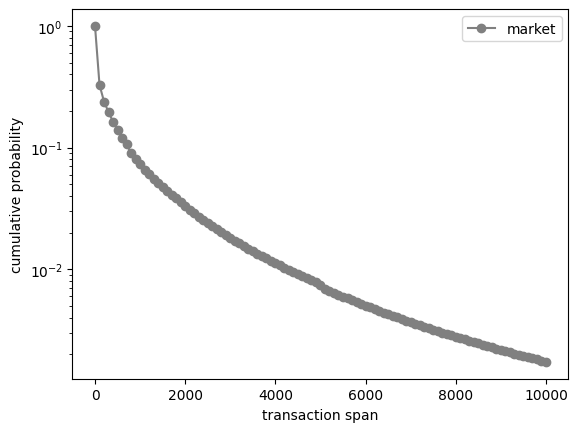

In [83]:
# [1] says transaction span obey exp(-kx). My data doesn't reproduce that feature
plt.plot(spans, cum_p, color="gray", label="market", marker="o")
plt.yscale("log")
plt.xlabel("transaction span")
plt.ylabel("cumulative probability")
plt.legend()
plt.show()

In [207]:
import random

class DeterministicDealerModelV2(DeterministicDealerModelV1):
    
    def __init__(self, num_agent, max_volatility=0.02, min_volatility=0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001) -> None:
        super().__init__(num_agent, max_volatility, min_volatility, trade_unit, initial_price, spread, initial_positions, tick_time)
        
    def standalize_ticks(self, ticks, alpha, tau):
        std_times = []
        
        pass
        
    def simulate(self, ticks_num: int, alpha=1.2, wma_seconds=150):
        prices, ticks = super().simulate(ticks_num)
        

In [ ]:
model = DeterministicDealerModelV2(30, max_volatility=0.05, spread=1)
prices, ticks = model.simulate(1000, tick_sma=150)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(ticks, [0.2 for i in ticks], [0.00001 for i in ticks], [-0.1 for i in ticks])
plt.plot([ticks[0], ticks[-1]], [0, 0], color="black")
plt.ylim(-0.3, 0.3)
plt.show()

### Validate statistical features

In [107]:
model = DeterministicDealerModelV2(300)
prices = model.simulate(10000, tick_sma=150)

In [68]:
tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.csv", index_col=0, parse_dates=True)

In [166]:
import numpy as np

def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

In [167]:
# remove market holiday
out_condition = 3600 * 24
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
min_span = time_diff[time_diff > 0].min()
time_span = np.round(time_diff/min_span)

In [168]:
# actual market result
pre_span = 0
counts = [len(time_span)]
spans = [*range(0, 1010, 10)]
for span in spans[1:]:
    match_spans = time_span[(time_span >= span)]
    count = len(match_spans)
    counts.append(count)
    pre_span = span
cum_p = np.asarray(counts)/len(time_span)

In [175]:
min_span = 0.001
time_diff = ticks[1:] - ticks[:-1]
model_time_span = np.round(time_diff)

In [178]:
# simulation result
pre_span = 0
counts = [len(model_time_span)]
sim_spans = [*range(0, 1002, 2)]
for span in sim_spans[1:]:
    match_spans = model_time_span[(model_time_span >= span)]
    count = len(match_spans)
    if count == 0:
        break
    counts.append(count)
    pre_span = span
sim_spans = sim_spans[:len(counts)]
sim_cum_p = np.asarray(counts)/len(model_time_span)

In [ ]:
plt.plot(spans, cum_p, color="gray", label="market")
plt.plot(sim_spans, sim_cum_p, color="blue", label="simulation")
plt.yscale("log")
plt.xlabel("transaction span")
plt.ylabel("cumulative probability")
plt.legend()
plt.show()

In [ ]:
# I couldn't reproduce a result of the reference [1]
plt.plot(sim_spans, sim_cum_p, color="blue", label="simulation")
plt.yscale("log")
plt.xlabel("transaction span")
plt.ylabel("cumulative probability")
plt.legend()
plt.show()

## V3: Improve volatility

In [83]:
import random
from collections.abc import Iterable

import numpy as np
import pandas as pd

class DeterministicDealerModelV3(DeterministicDealerModelV1):
    
    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001,
                 dealer_sensitive=None, wma=1, dealer_sensitive_min=-3.5, dealer_sensitive_max=-1.5
                 ) -> None:
        """_summary_

        Args:
            dealer_sensitive (int|Iterable, optional): this values represent sensitivity of each agent for past prices. greater/less than 0 means follower/contrarian. Defaults to None and initialized with random values by normal dist with mean and sigma
            wma (int|Iterable, optional): this values represent how long agents will be affected by past values. Defaults to 1.
        """
        super().__init__(num_agent, max_volatility, min_volatility, trade_unit, initial_price, spread, initial_positions, tick_time)
        self.price_history = [self.market_price]
        self.tick_times = [self.tick_time]
        
        if dealer_sensitive is None:
            # create array with random values between -1 to 1 
            self.dealer_sensitive = np.asarray([random.uniform(dealer_sensitive_min, dealer_sensitive_max) for i in range(num_agent)])
        elif isinstance(dealer_sensitive, (int, float)):
            # create array with fixed value
            self.dealer_sensitive = np.asarray([ dealer_sensitive for i in range(num_agent)])
        elif isinstance(dealer_sensitive, Iterable):
            # use provided array
            self.dealer_sensitive = np.asanyarray(dealer_sensitive)
        else:
            raise TypeError("dealer_sensitive must be either float or Iterable object")
        
        if isinstance(wma, int):
            # create weight array with random values between 0 to 1 
            self.weight_array = np.asarray([random.uniform(0, 1) for i in range(wma)])
            self.__total_weight = np.sum(self.weight_array)
            self.wma = wma
        elif isinstance(wma, Iterable):
            #  use wma as weight array
            self.weight_array = np.asarray(wma)
            self.__total_weight = np.sum(self.weight_array)
            self.wma = len(wma)
        else:
            raise TypeError("wma must be either int or Iterable object")
            
    
    def __wma(self):
        if len(self.price_history) >= self.wma + 1:
            wma_price = 0.0
            for i in range(1, self.wma+1):
                price_diff = self.price_history[-i] - self.price_history[-i -1]
                wma_price += (self.weight_array[i-1] * price_diff)
            return wma_price/self.__total_weight
        else:
            return 0
                
    def advance_order_price(self):
        follow_factors = self.dealer_sensitive * self.__wma()
        self.agent_df.price += self.agent_df.position * self.agent_df.tend + follow_factors
        return self.agent_df.price
            
    
    def simulate(self, ticks_num:int):
        for tick in range(ticks_num):
            self.tick_time += self.tick_time_unit
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                self.tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        return price_hist_df, np.asarray(self.tick_times)

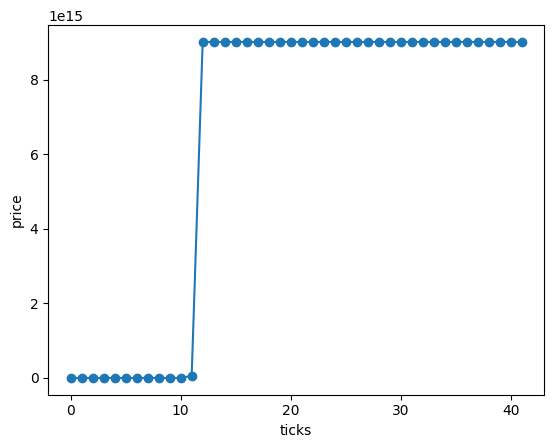

In [86]:
import matplotlib.pyplot as plt

model = DeterministicDealerModelV3(2, dealer_sensitive=0.5, initial_positions=[1, -1])
prices, ticks = model.simulate(1000)
plt.plot(prices, marker="o")
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

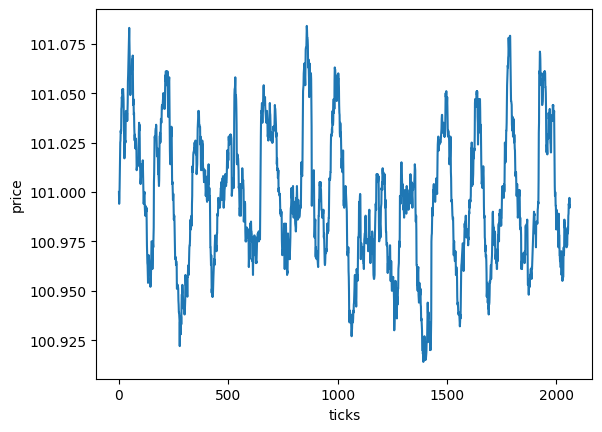

In [87]:
model = DeterministicDealerModelV3(300, dealer_sensitive=0.5)
prices, ticks = model.simulate(3000)
plt.plot(prices)
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

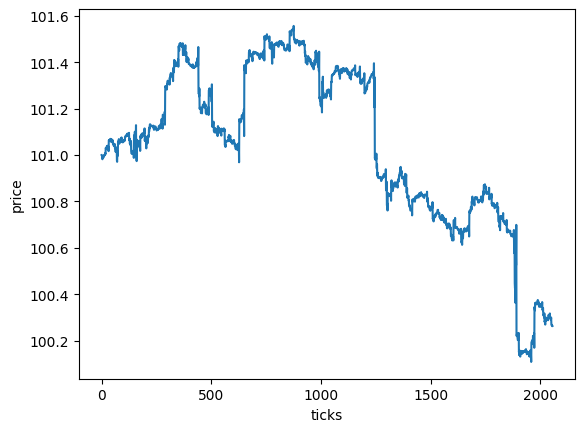

In [96]:
model = DeterministicDealerModelV3(300)
prices, ticks = model.simulate(3000)
plt.plot(prices)
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

### Validte statistical features

In [97]:
tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.csv", index_col=0, parse_dates=True)

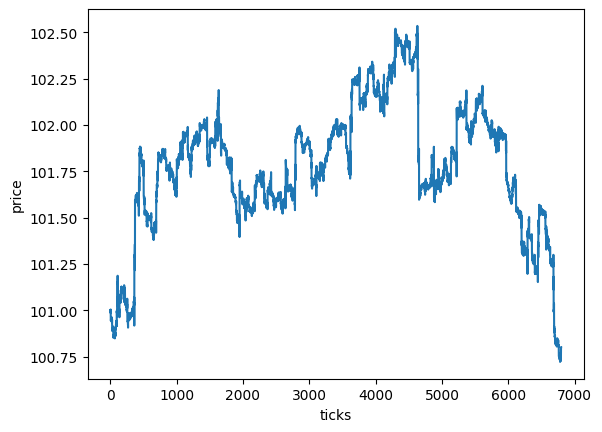

In [98]:
model = DeterministicDealerModelV3(300)
prices, ticks = model.simulate(10000)
plt.plot(prices)
plt.xlabel("ticks")
plt.ylabel("price")
plt.show()

In [99]:
import numpy as np

def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

In [100]:
mean = tick_df["price"].diff().mean()
std = tick_df["price"].diff().std()

cumulative, bin_edges = cumulative_dist(tick_df["price"].diff().abs().iloc[1:], bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
n_cumulative, n_bin_edges = cumulative_dist(data)

In [101]:
mean = prices["price"].diff().mean()
std = prices["price"].diff().std()

sim_cumulative, sim_bin_edges = cumulative_dist(prices["price"].diff().abs().iloc[1:], bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
sim_n_cumulative, sim_n_bin_edges = cumulative_dist(data)

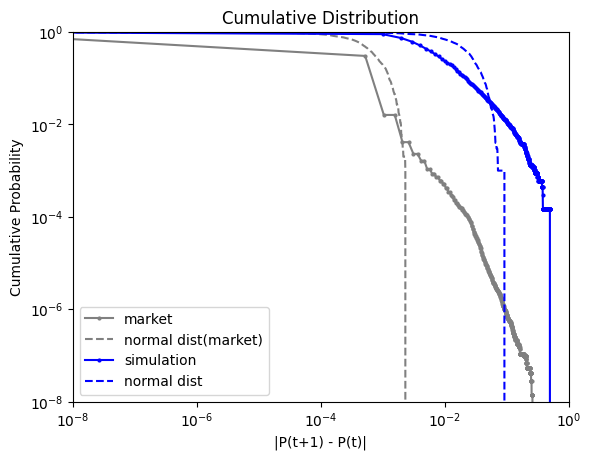

In [102]:
plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(n_bin_edges, n_cumulative, color="gray", linestyle="--", label="normal dist(market)")

plt.plot(sim_bin_edges, sim_cumulative, color="blue", marker="o", markersize=2, label="simulation")
plt.plot(sim_n_bin_edges, sim_n_cumulative, color="blue", linestyle="--", label="normal dist")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

In [103]:
def z(price_diff_srs, mean, std):
    return (price_diff_srs - mean)/std

def self_similarity(price_srs:pd.Series, k=100):
    base_mean = price_srs.mean()
    base_std = price_srs.std()
    base_z = z(price_srs, base_mean, base_std)
    
    sim_array = base_z.values * base_z.values
    similarities = [np.mean(sim_array)]
    sim_stds = [np.std(sim_array)]
    ks = [*range(0, k)]
    for i in ks[1:]:
        sim_array = base_z.values[i:] * base_z.values[:-i]
        mean_sim = np.mean(sim_array)
        std_sim = np.std(sim_array)
        similarities.append(mean_sim)
        sim_stds.append(std_sim)
    return ks, similarities, sim_stds

In [104]:
indices, similarities, _ = self_similarity(tick_df["price"].diff().iloc[1:], k=20)
sim_indices, sim_similarities, _ = self_similarity(prices["price"].diff().iloc[1:], k=20)

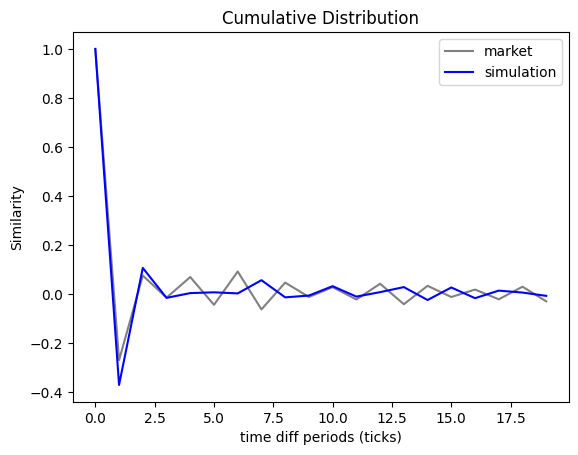

In [105]:
plt.plot(indices, similarities, color="gray", label="market")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

In [107]:
def diffusion(price_srs, n):
    if isinstance(price_srs, pd.Series):
        diff = price_srs.diff(periods=n).dropna()
        return diff.var()
    else:
        diff = (price_srs[:-n] - price_srs[n:])
        p_mean = (diff ** 2).mean()
        mean_p = (diff.mean()) ** 2
        return p_mean - mean_p

In [108]:
periods = [2**i for i in range(0, 11)]
var_diffusions = np.array([diffusion(tick_df["price"], period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

sim_var_diffusions = np.array([diffusion(prices["price"], period) for period in periods])
sim_std_diffusions = np.sqrt(sim_var_diffusions)

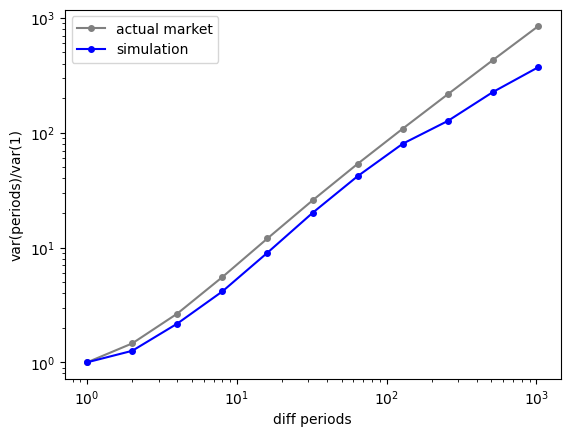

In [109]:
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color="gray", linestyle="-", marker="o", markersize=4)
plt.plot(periods, sim_var_diffusions/sim_var_diffusions[0], label="simulation", color="blue", linestyle="-", marker="o", markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("diff periods")
plt.ylabel("var(periods)/var(1)")
plt.legend()
plt.show()

In [ ]:
agent_num = 1000
initial_positions = [(-1)**i for i in range(agent_num)]
model = DeterministicDealerModelV3(agent_num, wma=3, initial_positions=initial_positions)
prices, ticks = model.simulate(10000)

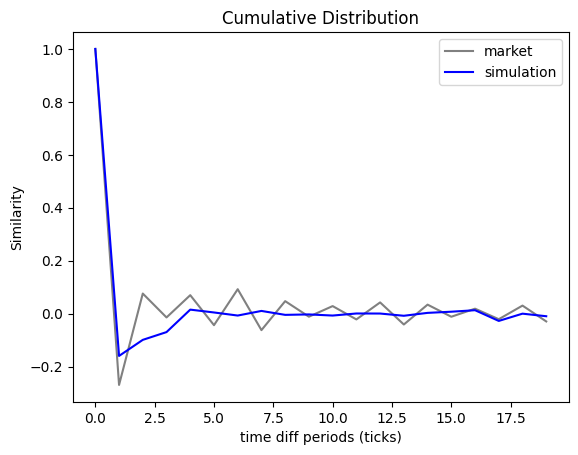

In [132]:
indices, similarities, _ = self_similarity(tick_df["price"].diff().iloc[1:], k=20)
sim_indices, sim_similarities, _ = self_similarity(prices["price"].diff().iloc[1:], k=20)

plt.plot(indices, similarities, color="gray", label="market")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

In [135]:
agent_num = 1000
initial_positions = [(-1)**i for i in range(agent_num)]
model = DeterministicDealerModelV3(agent_num, wma=10, initial_positions=initial_positions)
prices, ticks = model.simulate(10000)

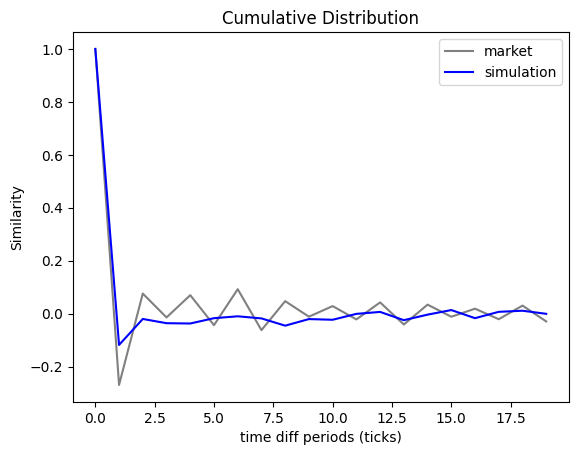

In [134]:
indices, similarities, _ = self_similarity(tick_df["price"].diff().iloc[1:], k=20)
sim_indices, sim_similarities, _ = self_similarity(prices["price"].diff().iloc[1:], k=20)

plt.plot(indices, similarities, color="gray", label="market")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

In [137]:
agent_num = 1000
initial_positions = [(-1)**i for i in range(agent_num)]
ma_weights = [1/(i**2) for i in range(1, 11)]
model = DeterministicDealerModelV3(agent_num, wma=ma_weights, initial_positions=initial_positions)
prices, ticks = model.simulate(10000)

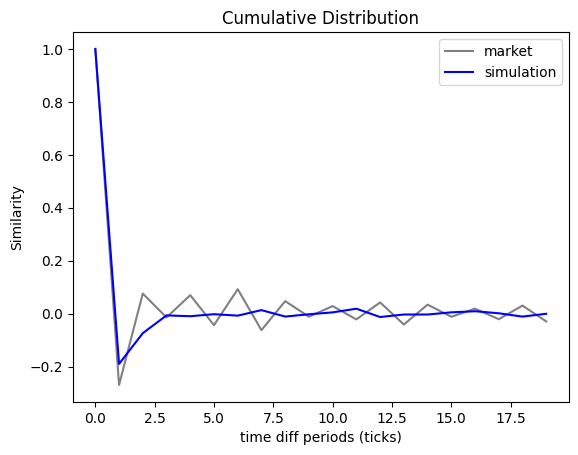

In [138]:
indices, similarities, _ = self_similarity(tick_df["price"].diff().iloc[1:], k=20)
sim_indices, sim_similarities, _ = self_similarity(prices["price"].diff().iloc[1:], k=20)

plt.plot(indices, similarities, color="gray", label="market")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

## V4: combine V2 and V3